# Visualization of words used in [*House of the Dragon Season 2*](https://en.wikipedia.org/wiki/House_of_the_Dragon) and their "rarity"

This notebook assumes the steps from `collect,ipynb` are already done. 

The necessary data are in `data` folder.

- `hotd-s2-words.csv`: processed word usage from show S2 scripts.
- `data4seo-word-trends-[90d,12m].json`: keyword trends data using DataforSEO API.

The figure outputs are saved in `figures` folder:

- `hotds2-rare-word-trends.svg`: Rare word trends (90d)
- `hotds2-stacked-word-trends-colored-by-base_freq_quartile.svg`: Individual word trends (more coarse), colored and sorted by word rareness
- `hotds2-stacked-word-trends-colored-by-log10_ratio_quartile.svg`: Individual word trends (more coarse), colored and sorted by their relative usage in the show scripts
- `hotds2-bulk-agg-word-trends.svg`: Bulk trends across time
- `hotds2-after-air-trends-vs-usage.svg`: Aggregate trends after show air and word's usage metrics


## Import packages & define paths

In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
from scipy import signal, interpolate

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# plot configs
rcParams['font.family'] = 'Overpass Nerd Font'
rcParams['font.size'] = 18
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 20
rcParams['patch.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 2
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = False
rcParams['savefig.facecolor'] = 'white'
rcParams['savefig.format'] = 'svg'
rcParams['savefig.pad_inches'] = 0.5
rcParams['savefig.bbox'] = 'tight'

In [3]:
# data file for word data frame
word_file_path = 'data/hotd-s2-words.csv'

In [4]:
# data file for dataforseo trend queries
trend_90d_file_path = 'data/data4seo-word-trends-90d.json'
trend_12m_file_path = 'data/data4seo-word-trends-12m.json'

In [5]:
# output figure directory
fig_dir = 'figures'

## Load word data

In [6]:
word_df = (
    pd.read_csv(word_file_path)
    .query('is_selected')
    .reset_index(drop=True)
)

word_df['air_date'] = pd.to_datetime(word_df['air_date'])
num_episodes = word_df['episode'].nunique()
word_df

word  script_freq     base_freq  est_syll  log10_ratio  \
0       advance     0.000226  4.470000e-05         3     0.703583   
1         aegon     0.007454  4.370000e-07         2     4.231923   
2         andal     0.000452  7.590000e-08         2     3.774679   
3        answer     0.000226  1.480000e-04         2     0.183629   
4         arryn     0.000226  1.740000e-07         2     3.113341   
..          ...          ...           ...       ...          ...   
592  victorious     0.000192  3.720000e-06         3     1.712286   
593     warrior     0.000192  1.450000e-05         2     1.121461   
594       waver     0.000192  5.620000e-07         2     2.533093   
595      winter     0.000192  7.760000e-05         2     0.392967   
596       wylde     0.000192  2.000000e-07         2     2.981799   

     is_high_rare  season  episode           episode_title  is_hotd  \
0           False       2        1         A Son for a Son    False   
1            True       2        1         A Son for a Son     True   
2            True       2        1         A Son for a Son     True   
3           False       2        1         A Son for a Son    False   
4            True       2        1         A Son for a Son     True   
..            ...     ...      ...                     ...      ...   
592         False       2        8  The Queen Who Ever Was    False   
593         False       2        8  The Queen Who Ever Was     True   
594          True       2        8  The Queen Who Ever Was    False   
595         False       2        8  The Queen Who Ever Was     True   
596          True       2        8  The Queen Who Ever Was     True   

     is_high_rare_selected  is_hotd_selected  is_other_selected  is_selected  \
0                    False             False               True         True   
1                    False              True              False         True   
2                    False              True              False         True   
3                    False             False               True         True   
4                    False              True              False         True   
..                     ...               ...                ...          ...   
592                  False             False               True         True   
593                  False              True              False         True   
594                  False             False               True         True   
595                  False              True              False         True   
596                  False              True              False         True   

      air_date  num_episodes  
0   2024-06-16             3  
1   2024-06-16             8  
2   2024-06-16             1  
3   2024-06-16             7  
4   2024-06-16             3  
..         ...           ...  
592 2024-08-04             1  
593 2024-08-04             2  
594 2024-08-04             2  
595 2024-08-04             3  
596 2024-08-04             3  

[597 rows x 16 columns]

In [7]:
word_first_appearance = (
    word_df.sort_values(['episode'])
    .groupby('word').head(1)
    .reset_index(drop=True)
)

word_first_appearance

word  script_freq     base_freq  est_syll  log10_ratio  \
0          advance     0.000226  4.470000e-05         3     0.703583   
1           rumble     0.000226  2.690000e-06         2     1.924138   
2        riverland     0.000678  7.940000e-08         3     3.931191   
3           refuse     0.000678  2.450000e-05         3     1.441846   
4       ratcatcher     0.000452  2.290000e-08         3     4.295085   
..             ...          ...           ...       ...          ...   
260          humor     0.000192  1.550000e-05         2     1.092497   
261       headsman     0.000192  3.470000e-08         2     3.742499   
262  halfheartedly     0.000192  6.170000e-08         4     3.492544   
263       godswood     0.000192  1.510000e-08         2     4.103852   
264       futilely     0.000192  7.590000e-08         4     3.402587   

     is_high_rare  season  episode           episode_title  is_hotd  \
0           False       2        1         A Son for a Son    False   
1           False       2        1         A Son for a Son    False   
2            True       2        1         A Son for a Son    False   
3           False       2        1         A Son for a Son    False   
4            True       2        1         A Son for a Son     True   
..            ...     ...      ...                     ...      ...   
260         False       2        8  The Queen Who Ever Was    False   
261          True       2        8  The Queen Who Ever Was    False   
262          True       2        8  The Queen Who Ever Was    False   
263          True       2        8  The Queen Who Ever Was    False   
264          True       2        8  The Queen Who Ever Was    False   

     is_high_rare_selected  is_hotd_selected  is_other_selected  is_selected  \
0                    False             False               True         True   
1                    False             False               True         True   
2                     True             False              False         True   
3                    False             False               True         True   
4                    False              True              False         True   
..                     ...               ...                ...          ...   
260                  False             False               True         True   
261                   True             False              False         True   
262                   True             False              False         True   
263                   True             False              False         True   
264                   True             False              False         True   

      air_date  num_episodes  
0   2024-06-16             3  
1   2024-06-16             4  
2   2024-06-16             7  
3   2024-06-16             4  
4   2024-06-16             4  
..         ...           ...  
260 2024-08-04             1  
261 2024-08-04             1  
262 2024-08-04             1  
263 2024-08-04             1  
264 2024-08-04             1  

[265 rows x 16 columns]

In [8]:
show_start_date = word_df['air_date'].min()
show_end_date = word_df['air_date'].max()

show_start_date, show_end_date

(Timestamp('2024-06-16 00:00:00'), Timestamp('2024-08-04 00:00:00'))

## Define time ranges

In [9]:
# summer start date
summer_startdate = pd.to_datetime('2024-06-01')

# max date of interest (relevant for 90d)
max_date = pd.to_datetime('2024-08-15')

# shift back a week for some leeway (relevant for 12m)
base_date = show_start_date - pd.Timedelta(7, unit='day')

## Fine-grained 90-day trends for highly used rare words

### Process trends data

In [10]:
def process_trends(
    trend_file,
    base_date=None,
):

    # load raw data
    with open(trend_file, 'r') as f:
        raw_data = json.load(f)

    assert all([len(x['result']) == 1 for x in raw_data])

    # get keyword trends data
    trend_df = []

    for rd in raw_data:
        assert len(rd['result']) == 1
        trends = [
            x for x in rd['result'][0]['items']
            if x['type'] == 'dataforseo_trends_graph'
        ]
        assert len(trends) == 1
        trends = trends[0]
        trends_words = trends['keywords']

        trends_data = pd.DataFrame(trends['data'])
        trends_data['word'] = [trends_words] * len(trends_data)
        trends_data = (
            trends_data.explode(['word', 'values'])
            .rename(columns={'values': 'value'})
            .astype({'value':'float'})
            .reset_index(drop=True)
        )
        trend_df.append(trends_data)

    trend_df = pd.concat(trend_df, ignore_index=True)

    # process dates
    trend_df['date_from'] = pd.to_datetime(trend_df['date_from'])
    trend_df['date_to'] = pd.to_datetime(trend_df['date_to'])
    trend_df['num_days'] = (trend_df['date_to'] - trend_df['date_from']).dt.days
    trend_df['date_center'] = (
        trend_df['date_from'] + 
        pd.to_timedelta(np.round(trend_df['num_days'] / 2), unit='d')
    )

    # stats for norm
    min_max_df = (
        trend_df.groupby('word')
        ['value'].agg(['min', 'max'])
        .add_suffix('_value')
        .astype('float')
        .reset_index()
    )

    # other stats with optionally from base
    stat_df_base_opt = (
        (
            trend_df.query('date_to < @base_date')
            if base_date is not None
            else trend_df
        )
        .groupby('word')
        ['value'].agg(
            mean = 'mean',
            std = 'std',
            median = 'median',
            iqr = lambda x: np.subtract(*np.percentile(x, [75, 25]))
        )
        .add_suffix('_value')
        .astype('float')
        .reset_index()
    )

    # merge stats
    trend_df = (
        trend_df
        .merge(
            min_max_df,
            how='left'
        )
        .merge(
            stat_df_base_opt,
            how='left'
        )
        .query('max_value > 0')
        .reset_index(drop=True)
    )

    # min-max normalize
    trend_df['mm_value'] = (
        (trend_df['value'] - trend_df['min_value']) / 
        (trend_df['max_value'] - trend_df['min_value'])
    )

    # zscore scaling
    trend_df['z_value'] = (
        (trend_df['value'] - trend_df['mean_value']) / 
        (trend_df['std_value'])
    )
    
    # robust scaling
    trend_df['r_value'] = (
        (trend_df['value'] - trend_df['median_value']) / 
        (trend_df['iqr_value'])
    )
    
    trend_df = trend_df.drop(columns=[
        'min_value', 'max_value',
        'mean_value', 'std_value',
        'median_value', 'iqr_value'
    ])
    
    return trend_df

In [11]:
# note: don't need zscore for this one
trend_df = process_trends(trend_90d_file_path)
trend_df

date_from    date_to   timestamp  value         word  num_days  \
0    2024-05-25 2024-05-25  1716595200    2.0        annal         0   
1    2024-05-25 2024-05-25  1716595200    4.0      armorer         0   
2    2024-05-25 2024-05-25  1716595200    0.0  comportment         0   
3    2024-05-25 2024-05-25  1716595200    1.0  conciliator         0   
4    2024-05-26 2024-05-26  1716681600    1.0        annal         0   
...         ...        ...         ...    ...          ...       ...   
5735 2024-08-21 2024-08-21  1724198400    3.0     woodpile         0   
5736 2024-08-22 2024-08-23  1724284800    2.0       whinny         1   
5737 2024-08-22 2024-08-23  1724284800    1.0     whosever         1   
5738 2024-08-22 2024-08-23  1724284800    4.0        wicke         1   
5739 2024-08-22 2024-08-23  1724284800   60.0     woodpile         1   

     date_center  mm_value   z_value  r_value  
0     2024-05-25  0.166667  0.412931    1.000  
1     2024-05-25  0.030303 -0.200145    0.000  
2     2024-05-25  0.000000 -0.250608      NaN  
3     2024-05-25  0.066667  0.346016      inf  
4     2024-05-26  0.000000 -0.493503    0.000  
...          ...       ...       ...      ...  
5735  2024-08-21  0.027027 -0.361620   -0.250  
5736  2024-08-22  0.043478 -0.731282   -0.700  
5737  2024-08-22  0.142857  0.385623    1.000  
5738  2024-08-22  0.030303 -0.654448   -0.625  
5739  2024-08-22  0.797297  4.805825   14.000  

[5740 rows x 10 columns]

### Select & process dates 

In [12]:
# select date range and convert date to summer / week days
trend_df = (
    trend_df
    .assign(date = pd.to_datetime(trend_df['date_from']))
    .query('date <= @max_date')
    .reset_index(drop=True)
)

# the selected date range should allow this
# if not, can remove
assert all(trend_df['date_from'] == trend_df['date_to'])

# filter only needed columns
# and add summer / week days if needed
# use `mm_value` aka min-max norm values onwards
trend_df = (
    trend_df
    .filter(['word', 'date', 'mm_value'])
    .assign(
        summer_day = (trend_df['date'] - summer_startdate).dt.days + 1,
        week_day = trend_df['date'].dt.strftime('%w').astype('int') + 1
    )
    .rename(columns={'mm_value': 'value'})
    .sort_values(['word', 'date'])
    .fillna({'value': 0})
    .reset_index(drop=True)
)

day_vec = np.arange(trend_df['summer_day'].min(), trend_df['summer_day'].max()+1)

# this is for peak detection
assert all(1 == (
    trend_df
    .groupby('word')
    ['date'].diff()
    .dropna()
    .dt.days
))

trend_df

word       date     value  summer_day  week_day
0        annal 2024-05-25  0.166667          -6         7
1        annal 2024-05-26  0.000000          -5         1
2        annal 2024-05-27  0.166667          -4         2
3        annal 2024-05-28  0.000000          -3         3
4        annal 2024-05-29  0.000000          -2         4
...        ...        ...       ...         ...       ...
5307  woodpile 2024-08-11  0.162162          72         1
5308  woodpile 2024-08-12  0.013514          73         2
5309  woodpile 2024-08-13  0.040541          74         3
5310  woodpile 2024-08-14  0.000000          75         4
5311  woodpile 2024-08-15  0.040541          76         5

[5312 rows x 5 columns]

### Detect & process peaks

In [13]:
peak_kws = dict(
    prominence=0.2, 
    height=0.3
)

In [14]:
def binarize_locations(locs, length):
    x = np.full(length, False)
    x[locs] = True
    return x

# find peaks
trend_df['is_peak'] = (
    trend_df.groupby('word')
    ['value'].apply(
        lambda x: binarize_locations(
            locs = signal.find_peaks(np.array(x), **peak_kws)[0],
            length = len(x)
        )
    )
    .explode()
    .astype('bool')
    .values
)

trend_df

word       date     value  summer_day  week_day  is_peak
0        annal 2024-05-25  0.166667          -6         7    False
1        annal 2024-05-26  0.000000          -5         1    False
2        annal 2024-05-27  0.166667          -4         2    False
3        annal 2024-05-28  0.000000          -3         3    False
4        annal 2024-05-29  0.000000          -2         4    False
...        ...        ...       ...         ...       ...      ...
5307  woodpile 2024-08-11  0.162162          72         1    False
5308  woodpile 2024-08-12  0.013514          73         2    False
5309  woodpile 2024-08-13  0.040541          74         3    False
5310  woodpile 2024-08-14  0.000000          75         4    False
5311  woodpile 2024-08-15  0.040541          76         5    False

[5312 rows x 6 columns]

Merge with `word_df` for air dates

In [15]:
peak_df = (
    trend_df.query('is_peak')
    .merge(
        word_first_appearance,
        how='left'
    )
    .rename(columns={
        'air_date': 'first_air_date'
    })
)
assert peak_df.isna().sum().sum() == 0

peak_df['first_air_summer_day'] = (peak_df['first_air_date'] - summer_startdate).dt.days + 1
peak_df['peak_delay'] = (peak_df['date'] - peak_df['first_air_date']).dt.days

peak_df['appear_after_before_ratio'] = (
    (day_vec.max() - peak_df['first_air_summer_day']) /
    (peak_df['first_air_summer_day'] - day_vec.min()) 
)

peak_df['first_episode'] = peak_df.apply(
    lambda x: x['episode'] if x['peak_delay'] >= 0 else -1,
    axis=1
)

In [16]:
# based on first episode appearances
word_order = list(
    peak_df
    .query('peak_delay >= 0')
    .sort_values(['episode', 'peak_delay'])
    ['word'].unique()
)

word_order.extend(list(set(peak_df['word']) - set(word_order)))

### Select words that may be influenced by the show

In [17]:
peak_count_df = (
    (
        peak_df.set_index([
            'word', 'appear_after_before_ratio',
        ])['peak_delay'] >= 0
    )
    .reset_index()
    .value_counts()
    .reset_index()
    .replace({'peak_delay': {True: 'after_air', False: 'before_air'}})
    .pivot(
        index=['word', 'appear_after_before_ratio'],
        columns='peak_delay',
        values='count'
    )
    .fillna(0).astype(int)
    .reset_index()
)
peak_count_df.columns.name = None

peak_count_df['total'] = peak_count_df['after_air'] + peak_count_df['before_air'] 
peak_count_df['trend_after_before_ratio'] = peak_count_df['after_air'] / peak_count_df['before_air'] 

# peak_count_df['trend_after_air_ratio'] = peak_count_df['after_air'] / peak_count_df['total'] 

peak_count_df

word  appear_after_before_ratio  after_air  before_air  total  \
0         annal                   0.281250          2           3      5   
1       armorer                   0.906977          1           0      1   
2   comportment                   0.281250          1           1      2   
3   conciliator                   1.277778          1           1      2   
4         coope                   1.827586          5           1      6   
..          ...                        ...        ...         ...    ...   
59     weirwood                   0.906977          3           0      3   
60       whinny                   1.277778          3           1      4   
61     whosever                   1.827586          4           0      4   
62        wicke                   1.827586          0           2      2   
63     woodpile                   0.281250          0           2      2   

    trend_after_before_ratio  
0                   0.666667  
1                        inf  
2                   1.000000  
3                   1.000000  
4                   5.000000  
..                       ...  
59                       inf  
60                  3.000000  
61                       inf  
62                  0.000000  
63                  0.000000  

[64 rows x 6 columns]

In [18]:
thres_ratio = 2

selected_high_rare = word_df.query('is_high_rare_selected')['word'].unique()

selected_word_df = (
    peak_count_df
    .query(
        '(after_air > 0 and before_air == 0) or '
        '(trend_after_before_ratio > @thres_ratio * appear_after_before_ratio)'
    )
    .sort_values(
        ['trend_after_before_ratio', 'after_air', 'before_air'],
        ascending=[False, False, True]
    )
    .query('word in @selected_high_rare')
    .reset_index(drop=True)
)

selected_words = selected_word_df['word'].to_list()
selected_word_df

word  appear_after_before_ratio  after_air  before_air  total  \
0      shipwright                   2.727273          5           0      5   
1    forthrightly                   1.827586          4           0      4   
2   impetuousness                   1.827586          4           0      4   
3      redcurrant                   1.277778          4           0      4   
4        whosever                   1.827586          4           0      4   
5        weirwood                   0.906977          3           0      3   
6     dragonrider                   1.277778          2           0      2   
7          ribbit                   0.906977          2           0      2   
8         sheathe                   1.827586          2           0      2   
9      stablehand                   0.281250          2           0      2   
10        armorer                   0.906977          1           0      1   
11         dotard                   0.438596          1           0      1   
12       godswood                   0.154930          1           0      1   
13        pliancy                   1.277778          1           0      1   
14      untamable                   2.727273          1           0      1   
15      riverland                   2.727273          6           1      7   
16          coope                   1.827586          5           1      6   
17       unstrung                   1.827586         12           3     15   
18         foible                   0.640000          3           1      4   
19         whinny                   1.277778          3           1      4   
20      unsheathe                   0.906977          4           2      6   
21        lowborn                   0.281250          2           1      3   
22   overcautious                   0.438596          4           4      8   
23        gainsay                   0.281250          2           2      4   
24      sweetmeat                   0.154930          2           2      4   
25    comportment                   0.281250          1           1      2   
26    lickspittle                   0.438596          1           1      2   
27          annal                   0.281250          2           3      5   

    trend_after_before_ratio  
0                        inf  
1                        inf  
2                        inf  
3                        inf  
4                        inf  
5                        inf  
6                        inf  
7                        inf  
8                        inf  
9                        inf  
10                       inf  
11                       inf  
12                       inf  
13                       inf  
14                       inf  
15                  6.000000  
16                  5.000000  
17                  4.000000  
18                  3.000000  
19                  3.000000  
20                  2.000000  
21                  2.000000  
22                  1.000000  
23                  1.000000  
24                  1.000000  
25                  1.000000  
26                  1.000000  
27                  0.666667

### Visualize of words that are *possibly* influenced by the show

In [19]:
selected_word_order = [
    x for x in word_order if x in selected_words
][::-1]

selected_trends = (
    trend_df
    .query('word in @selected_words')
    .reset_index(drop=True)
)

selected_trends['word_idx'] = selected_trends['word'].map({
    x: i for i, x in enumerate(selected_word_order)
})
    
selected_trends['value'] = selected_trends['value']*0.8 + selected_trends['word_idx'] 

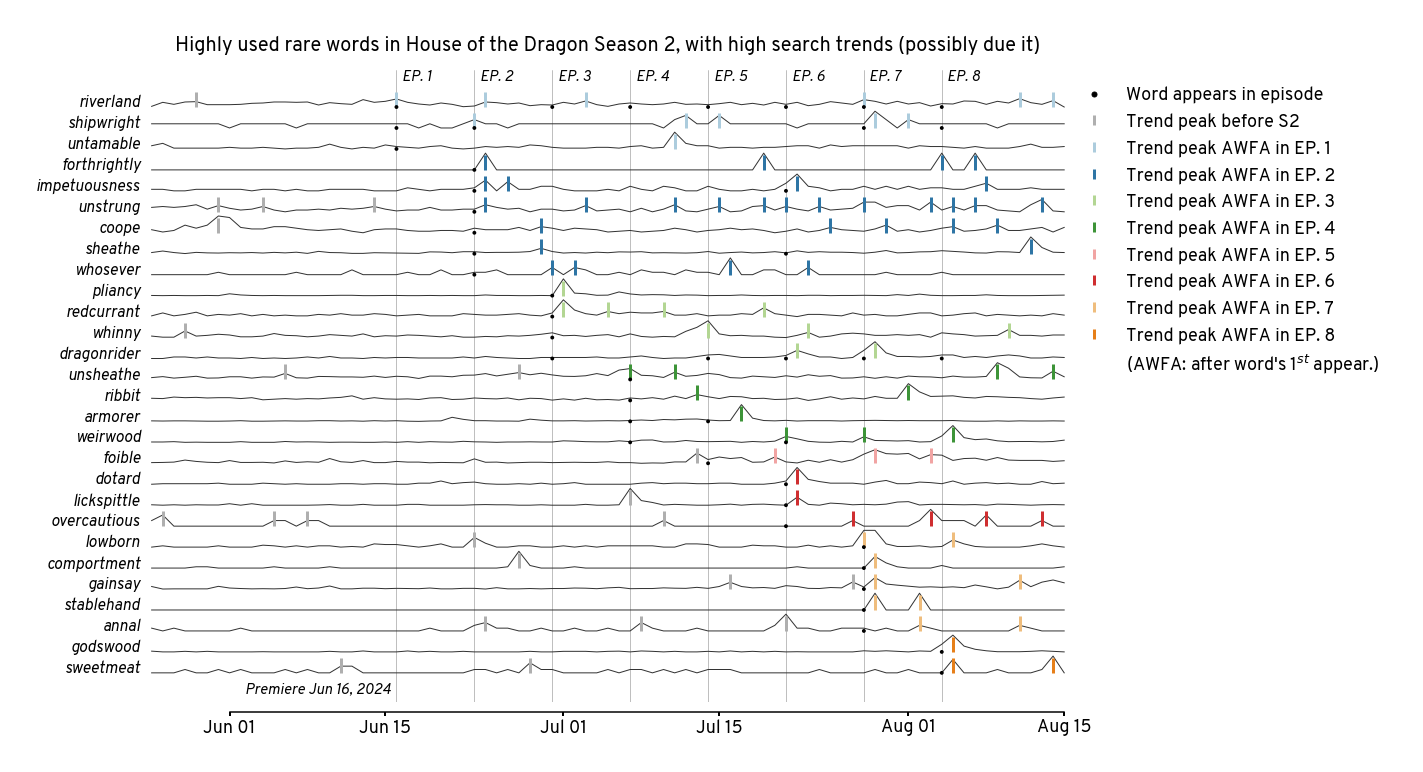

In [20]:
plt.figure(figsize=(19,10))

first_ep_cmap = dict(zip(
    [-1] + list(range(1,num_episodes+1,1)),
    ['#afafaf'] + sns.color_palette('Paired', num_episodes, desat=0.8)
))

# plot peak ~ markers
sns.stripplot(
    peak_df.query('word in @selected_words'),
    x='date',
    y='word',
    hue='first_episode',
    order=selected_word_order,
    orient='y',
    hue_order=first_ep_cmap.keys(),
    palette=first_ep_cmap,
    marker=2,
    s=15,
    linewidth=3,
    jitter=0,
    zorder=3,
)

# overlay (shifted) trend series
sns.lineplot(
    selected_trends,
    x='date',
    y='value',
    units='word',
    estimator=None,
    lw=1,
    c='.2',
    zorder=2,
)

# when word appears
sns.scatterplot(
    word_df.query('word in @selected_words'),
    x='air_date',
    y='word',
    c='k',
    zorder=3,
    marker='.',
    edgecolor='none',
    s=60,
)

# when episode airs
[
    plt.axvline(x=x, color='.5', ls='-', lw=0.5, zorder=1)
    for x in word_df['air_date'].drop_duplicates()
]

# put episode names
[
    plt.text(
        x=r['air_date'] + pd.Timedelta('12h'),
        y=len(selected_words) + 0.25, 
        s='EP. %d'%(r['episode']),
        fontstyle='italic',
        fontsize=15
    )
    for _, r in word_df[['episode','air_date',]].drop_duplicates().iterrows()
]

plt.text(
    x=show_start_date - pd.Timedelta('12h'),
    y=-1,
    s=show_start_date.strftime('Premiere %b %d, %Y'), 
    fontstyle='italic',
    fontsize=15,
    ha='right'
)

# put words right next to trends (aka y-axis removed)
[
    plt.text(
        x=trend_df['date'].min() - pd.Timedelta('1D'),
        y=w,
        s=w,
        fontstyle='italic',
        ha='right',
        fontsize=16
    )
    for w in selected_words
]

# legends
plt.legend(
    handles=[
        plt.Line2D(
            [0],[0],
            label='Word appears in episode',
            color='k',
            marker='.',
            ls='none',
            markersize=10
        )
    ] + [
        plt.Line2D(
            [0],[0],
            label=(
                'Trend peak AWFA in EP. %d' %(k) if k > 0 
                else 'Trend peak before S2'
            ),
            color=v,
            marker='|',
            ls='none',
            markersize=10,
            markeredgewidth=3
        )
        for k, v in first_ep_cmap.items()
    ] + [
        plt.Line2D(
            [0], [0],
            label = "(AWFA: after word's 1$^{st}$ appear.)",
            color = 'none',
            ls='none',
        )
    ],
    bbox_to_anchor = (0.95,1),
    frameon=False,
    fontsize=18,
)


plt.gca().invert_yaxis()
plt.yticks([])
plt.xlabel(None)
plt.ylabel(None)
sns.despine(trim=True, offset=10, left=True)

plt.title(
    'Highly used rare words in House of the Dragon Season 2, ' \
    'with high search trends (possibly due it)', 
    y=1.02
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()

plt.savefig('figures/hotds2-rare-word-trends.png')
plt.savefig('figures/hotds2-rare-word-trends.svg')
plt.show()


## Coarse 12-month trends for different highly used words

### Process trends data

In [21]:
def interpolate_trends(
    trend_df,
    freq='7d',
    xcol='date_from',
    interp1d_kws=dict()
):
    date_vec = pd.date_range(
        trend_df['date_from'].min(),
        trend_df['date_to'].max(),
        freq=freq
    )

    trend_df = (
        trend_df
        .groupby(['word'])
        .apply(
            lambda x: pd.DataFrame({
                k: interpolate.interp1d(
                    x=(x[xcol] - date_vec.min()).dt.days.to_numpy(),
                    y=x[k],
                    **interp1d_kws
                )(
                    (date_vec - date_vec.min()).days   
                )
                for k in trend_df.filter(regex='.*value.*').columns
            }).assign(date = date_vec),
            include_groups=False
        )
        .reset_index()
    )

    trend_df = trend_df.drop(
        columns=trend_df.filter(regex='level_\d+').columns
    )
    
    return trend_df

In [22]:
# need to normalize by the base period (i.e. before the show)
# in order to plot the comparisons
trend_df = process_trends(
    trend_12m_file_path,
    base_date=base_date,
)

trend_df

date_from    date_to   timestamp  value         word  num_days  \
0     2023-09-10 2023-09-16  1694304000    0.0     aggrieve         6   
1     2023-09-10 2023-09-16  1694304000   12.0        annal         6   
2     2023-09-10 2023-09-16  1694304000   37.0      armorer         6   
3     2023-09-10 2023-09-16  1694304000    5.0  comportment         6   
4     2023-09-10 2023-09-16  1694304000    0.0  conciliator         6   
...          ...        ...         ...    ...          ...       ...   
13007 2024-09-01 2024-09-06  1725148800   36.0      darling         5   
13008 2024-09-01 2024-09-06  1725148800   17.0     terrible         5   
13009 2024-09-01 2024-09-06  1725148800   10.0   constantly         5   
13010 2024-09-01 2024-09-06  1725148800   44.0       rumble         5   
13011 2024-09-01 2024-09-06  1725148800   51.0     anything         5   

      date_center  mm_value   z_value   r_value  
0      2023-09-13  0.000000 -0.466394       NaN  
1      2023-09-13  0.315789 -0.867515 -0.545455  
2      2023-09-13  0.136986 -0.651425 -0.500000  
3      2023-09-13  0.131579  0.275681  0.666667  
4      2023-09-13  0.000000 -1.364354 -1.000000  
...           ...       ...       ...       ...  
13007  2024-09-03  0.666667  2.751815  2.750000  
13008  2024-09-03  1.000000  3.854734  2.500000  
13009  2024-09-03  0.800000  1.816268  1.000000  
13010  2024-09-03  0.222222 -0.318202 -0.062500  
13011  2024-09-03  1.000000  2.268248  2.333333  

[13012 rows x 10 columns]

In [23]:
# interpolate so that taking averages / medians
# in `sns.relplot/lineplot` is valid
# to avoid cases with sparse time points
trend_df = interpolate_trends(
    trend_df,
    freq='7d',
    xcol='date_from',
    interp1d_kws=dict(
        kind='slinear',
        fill_value='extrapolate'
    )
)

### Merge with word metadata

In [24]:
word_meta_df = (
    word_df
    .sort_values('log10_ratio')
    .groupby('word').tail(1)
    .filter(regex='word|freq|ratio|is_.*_selected')
)

assert (
    word_meta_df
    .filter(regex='is_.*')
    .any(axis=1)
    .all()
)

word_meta_df = (
    word_meta_df
    .melt(
        id_vars=['word', 'script_freq', 'base_freq', 'log10_ratio'],
        var_name='category'
    )
    .query('value')
    .drop(columns='value')
    .groupby(['word', 'category'])
    .agg('median')
    .reset_index()
)

In [25]:
word_meta_df['category'] = (
    word_meta_df['category']
    .str.replace('is_', '')
    .str.replace('_selected', '')
    .map({
        'other': 'other',
        'hotd': 'show-specific',
        'high_rare': 'highly used & rare',
    })
)

In [26]:
for k in ['script_freq', 'base_freq', 'log10_ratio']:
    word_meta_df[k + '_quartile'] = pd.qcut(
        word_meta_df[k],
        4,
        labels=['Q' + str(x+1) for x in range(4)],
        precision=10
    )

In [27]:
word_meta_df

word            category  script_freq     base_freq  log10_ratio  \
0         abe               other     0.000498  4.170000e-06     2.077172   
1        able               other     0.000332  2.690000e-04     0.091465   
2     achieve               other     0.000212  3.720000e-05     0.756252   
3       addam       show-specific     0.000837  1.780000e-08     4.672333   
4     advance               other     0.000487  4.470000e-05     1.037198   
..        ...                 ...          ...           ...          ...   
260    winter       show-specific     0.001807  7.760000e-05     1.367119   
261     woman       show-specific     0.001217  2.240000e-04     0.735197   
262  woodpile  highly used & rare     0.000279  7.080000e-08     3.595599   
263    worker       show-specific     0.000391  2.690000e-05     1.162262   
264     wylde       show-specific     0.000279  2.000000e-07     3.144602   

    script_freq_quartile base_freq_quartile log10_ratio_quartile  
0                     Q3                 Q3                   Q2  
1                     Q3                 Q4                   Q1  
2                     Q2                 Q4                   Q1  
3                     Q4                 Q1                   Q4  
4                     Q3                 Q4                   Q1  
..                   ...                ...                  ...  
260                   Q4                 Q4                   Q2  
261                   Q4                 Q4                   Q1  
262                   Q3                 Q2                   Q3  
263                   Q3                 Q4                   Q1  
264                   Q3                 Q2                   Q3  

[265 rows x 8 columns]

In [28]:
trend_df = trend_df.merge(
    word_meta_df,    
    how='left',
    on='word'
)

trend_df

word  value  mm_value   z_value  r_value       date       category  \
0        abe   34.0  0.209302  0.743071      0.4 2023-09-10          other   
1        abe   35.0  0.232558  1.058068      0.6 2023-09-17          other   
2        abe   32.0  0.162791  0.113076      0.0 2023-09-24          other   
3        abe   29.0  0.093023 -0.831916     -0.6 2023-10-01          other   
4        abe   28.0  0.069767 -1.146914     -0.8 2023-10-08          other   
...      ...    ...       ...       ...      ...        ...            ...   
13047  wylde    2.0  0.333333  0.267418      NaN 2024-08-04  show-specific   
13048  wylde    2.0  0.333333  0.267418      NaN 2024-08-11  show-specific   
13049  wylde    2.0  0.333333  0.267418      NaN 2024-08-18  show-specific   
13050  wylde    2.0  0.333333  0.267418      NaN 2024-08-25  show-specific   
13051  wylde    2.0  0.333333  0.267418      NaN 2024-09-01  show-specific   

       script_freq     base_freq  log10_ratio script_freq_quartile  \
0         0.000498  4.170000e-06     2.077172                   Q3   
1         0.000498  4.170000e-06     2.077172                   Q3   
2         0.000498  4.170000e-06     2.077172                   Q3   
3         0.000498  4.170000e-06     2.077172                   Q3   
4         0.000498  4.170000e-06     2.077172                   Q3   
...            ...           ...          ...                  ...   
13047     0.000279  2.000000e-07     3.144602                   Q3   
13048     0.000279  2.000000e-07     3.144602                   Q3   
13049     0.000279  2.000000e-07     3.144602                   Q3   
13050     0.000279  2.000000e-07     3.144602                   Q3   
13051     0.000279  2.000000e-07     3.144602                   Q3   

      base_freq_quartile log10_ratio_quartile  
0                     Q3                   Q2  
1                     Q3                   Q2  
2                     Q3                   Q2  
3                     Q3                   Q2  
4                     Q3                   Q2  
...                  ...                  ...  
13047                 Q2                   Q3  
13048                 Q2                   Q3  
13049                 Q2                   Q3  
13050                 Q2                   Q3  
13051                 Q2                   Q3  

[13052 rows x 13 columns]

### Prepare for visualization

In [29]:
viz_start_date = pd.Timestamp('2024-02-01')
viz_stop_date = pd.Timestamp('2024-09-07')

In [30]:
cat_cmap = {
    'show-specific': '#b2182b',
    'highly used & rare': '#2166ac',
    'other': '#969696',
}


In [31]:
trend_df = trend_df.merge(
    trend_df
    .groupby(['category', 'word'])
    ['z_value'].max()
    .reset_index()
    .set_index('word')
    .groupby('category')
    .rank(method='dense')
    .rename(columns={'z_value': 'rank_z'})
    .reset_index()
)

In [32]:
for k in ['script_freq', 'base_freq', 'log10_ratio']:
    trend_df['rank_' + k] = (
        trend_df
        .groupby('category')
        [k].rank(method='dense', ascending='base' in k)
    )

In [33]:
usage_order = ['Word rareness','Relative usage']
coarse_cat_cmap = {
    'show-specific': '#b2182b',
    'non show-specific': '#969696',
}

In [34]:
agg_show_df = (
    trend_df.query('date >= @show_start_date')
    .groupby(['word', 'category', 'base_freq', 'log10_ratio'])
    ['z_value'].agg('median')
    .reset_index()
    .rename(columns={'log10_ratio': 'Relative usage'})
)

agg_show_df['Word rareness'] = -np.log10(agg_show_df.pop('base_freq'))

agg_show_df['category'] = agg_show_df['category'].apply(
    lambda x: 'non show-specific' if 'show' not in x else x
)   

agg_show_df = agg_show_df.melt(
    id_vars=['word', 'category', 'z_value'],
    var_name='word_metric',
)

agg_show_df

word           category   z_value     word_metric     value
0         abe  non show-specific  0.900569  Relative usage  2.077172
1        able  non show-specific -1.673570  Relative usage  0.091465
2     achieve  non show-specific -0.537890  Relative usage  0.756252
3       addam      show-specific  4.245661  Relative usage  4.672333
4     advance  non show-specific -0.096027  Relative usage  1.037198
..        ...                ...       ...             ...       ...
497    winter      show-specific -0.674498   Word rareness  4.110138
498     woman      show-specific  0.648381   Word rareness  3.649752
499  woodpile  non show-specific  0.623807   Word rareness  7.149967
500    worker      show-specific -0.210060   Word rareness  4.570248
501     wylde      show-specific  0.267418   Word rareness  6.698970

[502 rows x 5 columns]

### Visualize individual trends

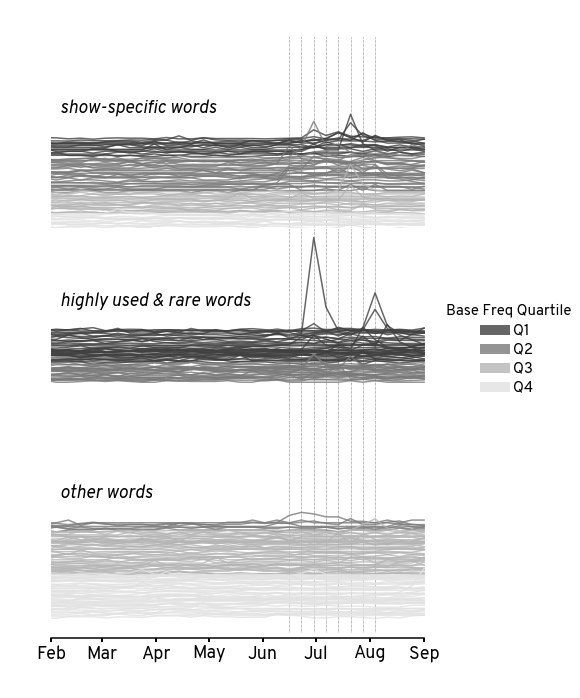

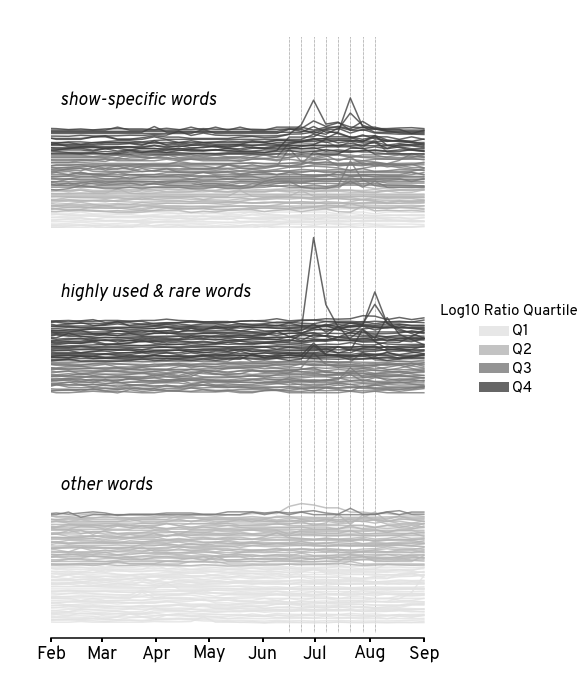

In [35]:
for hue_col, cmap in zip(
    ['base_freq_quartile','log10_ratio_quartile'], 
    ['Greys_r', 'Greys']
):
    rank_vec = trend_df['rank_' + hue_col.replace('_quartile', '')]

    trend_df['shifted_z_value'] = (
        trend_df['z_value'] * 0.8 
        - rank_vec
    )
    
    g = sns.relplot(
        trend_df,
        x='date',
        # y='z_value',
        y='shifted_z_value',
        hue=hue_col, 
        palette=cmap,
        units='word',estimator=None,
        row_order=cat_cmap.keys(),
        row='category',
        kind='line',
        n_boot=10,
        zorder=2,
        height=3,
        aspect=2,
        alpha=0.8,
    )

    [
        g.refline(x=x, color='k', ls=':', lw=0.5, zorder=1)
        for x in word_df['air_date'].drop_duplicates()
    ]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    g.set_titles('')
    g.set_xlabels('')
    g.set_ylabels('')

    plt.xlim([viz_start_date,viz_stop_date])

    for i, (k, ax) in enumerate(g.axes_dict.items()):
        hide_xaxis = i < (len(g.axes) - 1)
        sns.despine(
            trim=True, offset=5,
            left=True,
            bottom = hide_xaxis, 
            ax=ax
        )
        ax.label_outer(True)
        ax.set_yticks([])
        ax.text(
            x=viz_start_date + pd.Timedelta('5d'),
            y=20,
            s=k + ' words',
            fontstyle='italic',
            fontsize=18
        )

    g.legend.get_title().set_fontsize(15)
    g.legend.get_title().set_text(hue_col.replace('_', ' ').title())
    [l.set_linewidth(10) for l in g.legend.get_lines()]
    [t.set_fontsize(15) for t in g.legend.texts]

    g.tight_layout(h_pad=-2)
    
    plt.savefig(f'figures/hotds2-stacked-word-trends-colored-by-{hue_col}.png')
    plt.savefig(f'figures/hotds2-stacked-word-trends-colored-by-{hue_col}.svg')


### Visualize bulk trends 

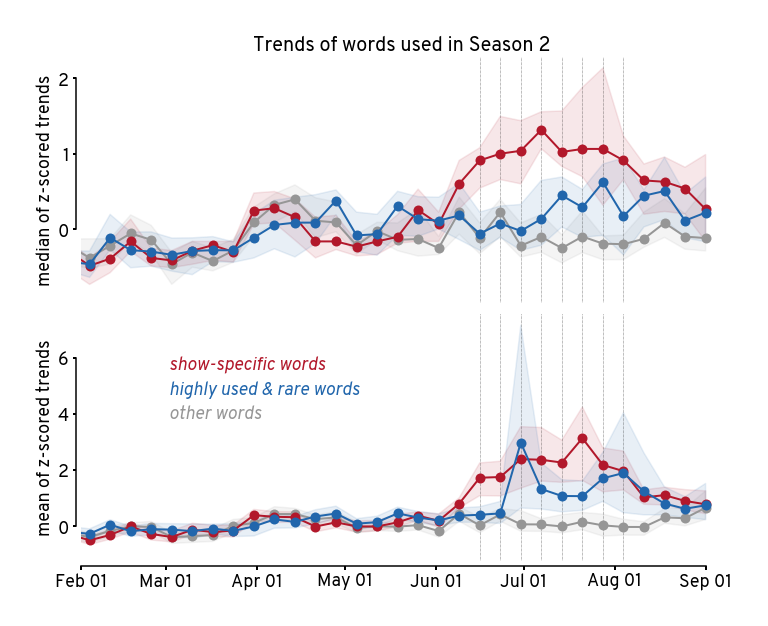

In [36]:
plt.figure(figsize=(10,8))

for i, est_fn in enumerate([
    np.nanmedian, np.nanmean
]):

    plt.subplot(2,1,i+1)
    sns.lineplot(
        trend_df,
        x='date',
        y='z_value',
        hue='category',
        palette=cat_cmap,
        errorbar=('ci', 95),
        estimator=est_fn,
        marker='o',
        markersize=10,
        markeredgecolor='none',
        n_boot=50,
        zorder=2,
        lw=2,
        legend=False,
        err_kws={'alpha':0.1}
    )
    
    [
        plt.axvline(x=x, color='k', ls=':', lw=0.5, zorder=1)
        for x in word_df['air_date'].drop_duplicates()
    ]

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xlim([viz_start_date,viz_stop_date])
    
    plt.xlabel(None)
    ylim_vec = plt.gca().get_ylim()
    
    
    if i == 0:
        plt.title('Trends of words used in Season 2')
        plt.xticks([])
    else:
        [
            plt.text(
                x=viz_start_date + pd.Timedelta('30d'),
                y=max(ylim_vec) - 0.85*j - 2,
                s=cat + ' words',
                c=col,
                fontsize=18,
                fontstyle='italic'
            ) for j, (cat, col) in enumerate(cat_cmap.items())
        ]
    
        
    plt.ylabel(f'{est_fn.__name__.replace("nan","")} of z-scored trends')
    sns.despine(trim=True, offset=5, ax=plt.gca(), bottom=i==0)
    
plt.tight_layout()

plt.savefig('figures/hotds2-bulk-agg-word-trends.png')
plt.savefig('figures/hotds2-bulk-agg-word-trends.svg')

plt.show()

### Visualize aggregate after show

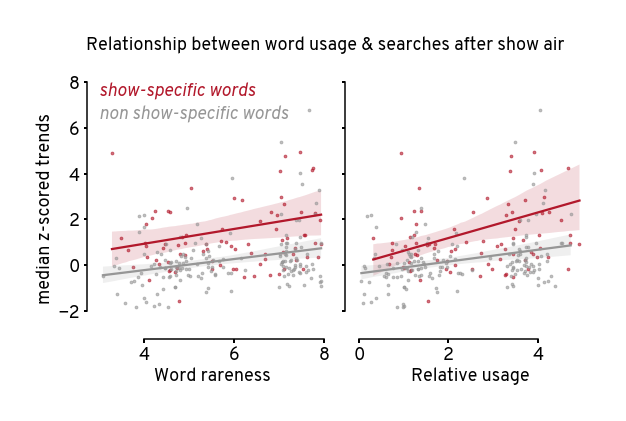

In [37]:
g = sns.lmplot(
    agg_show_df,
    x='value',
    y='z_value',
    hue='category',
    col='word_metric',
    col_order=usage_order,
    palette=coarse_cat_cmap,
    hue_order=coarse_cat_cmap.keys(),
    markers='.',
    scatter_kws={'s': 30, 'alpha': 0.6},
    aspect=0.8,
    height=5,
    legend=False,
    facet_kws={'sharex':False},
)

plt.ylim([-3, 8])

g.set_titles('')
g.set_ylabels('median z-scored trends')

[
    g.axes[0,0].text(
        x=3, y=8-i, s=cat + ' words', c=col,
        fontsize=18, fontstyle='italic', va='top'
    ) for i, (cat, col) in enumerate(coarse_cat_cmap.items())
]

[
    ax.set_xlabel(k) for k, ax in g.axes_dict.items()
]

g.fig.suptitle(
    'Relationship between word usage & searches after show air',
    fontsize=18, y=1, x=0.52,
)
sns.despine(trim=True, offset=5)
g.tight_layout(w_pad=1)


plt.savefig('figures/hotds2-after-air-trends-vs-usage.png')
plt.savefig('figures/hotds2-after-air-trends-vs-usage.svg')

plt.show()
